In [1]:
import os
import mpld3
import numpy as np
import pandas as pd
import cv2
import matplotlib.pylab as plt
from scipy.ndimage import gaussian_filter
import cv2
from tqdm import tqdm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from glob import glob

#  Load All Videos From a Folder

In [2]:
video_folder='video_raw/2801_onp/'
file_list = []

for file in glob(video_folder+'*.mp4'):
    #print(file)
    file_list.append(file)

In [3]:
print("Lenght of file: ",len(file_list))

Lenght of file:  15


In [4]:
def readRGBImage(imagepath):
    image = cv.imread(imagepath)                     # Height, Width, Channel
    (major, minor, _) = cv.__version__.split(".")
    if major == '3':
        image = cv2.cvtColor(imagepath, cv2.COLOR_BGR2RGB)
    else:
        pass
    return image

In [5]:
def saveRGBImage(imagepath, raw):
    converted_img =cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(imagepath, converted_img)

In [6]:
def video2Frame(file):
    count = 0
    cap = cv2.VideoCapture(file)    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
    n = 32       # Images Pixel Resize 32X32 
    dim = (n,n)
    s_value=[]

    pbar = tqdm(total=length)            #Loading bar 

    while(count!=length):

        pbar.update(1)      
        ret, frame = cap.read()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        imageR = img.copy()
        imageR[:, :, 1:3] = 0

        resized = cv2.resize(imageR, dim)
        (h, w) = resized.shape[:2]
        center = (w / 2, h / 2)
        angle90 = -90
        scale = 1.0

        M = cv2.getRotationMatrix2D(center, angle90, scale)
        rotated90 = cv2.warpAffine(resized, M, (h, w))
        r = rotated90.flatten()
        avg_r= np.average(r)               #Average R of Each Pixel 
        s_value.append(avg_r)              # Single R value from an Entire Frame(Image)  
        count+=1
        #saveRGBImage('r_channel/r_d'+str(count)+'.jpg', rotated90)

    pbar.close()

    return s_value

# Preprocess All The Videos at Once 

In [7]:
file_s_value=[]

for file in file_list:
    temp = video2Frame(file)
    file_s_value.append(temp)

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1792/1809 [00:32<00:00, 57.36it/s]

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1795/1809 [00:50<00:00, 57.36it/s]

In [ ]:
df = pd.DataFrame(file_s_value)
df.to_csv(video_folder+'/list_onp.csv', index=False)

In [ ]:
signal = pd.read_csv(video_folder+'list_onp.csv', delimiter = ",")
signalT=signal.T

<IPython.core.display.Javascript object>


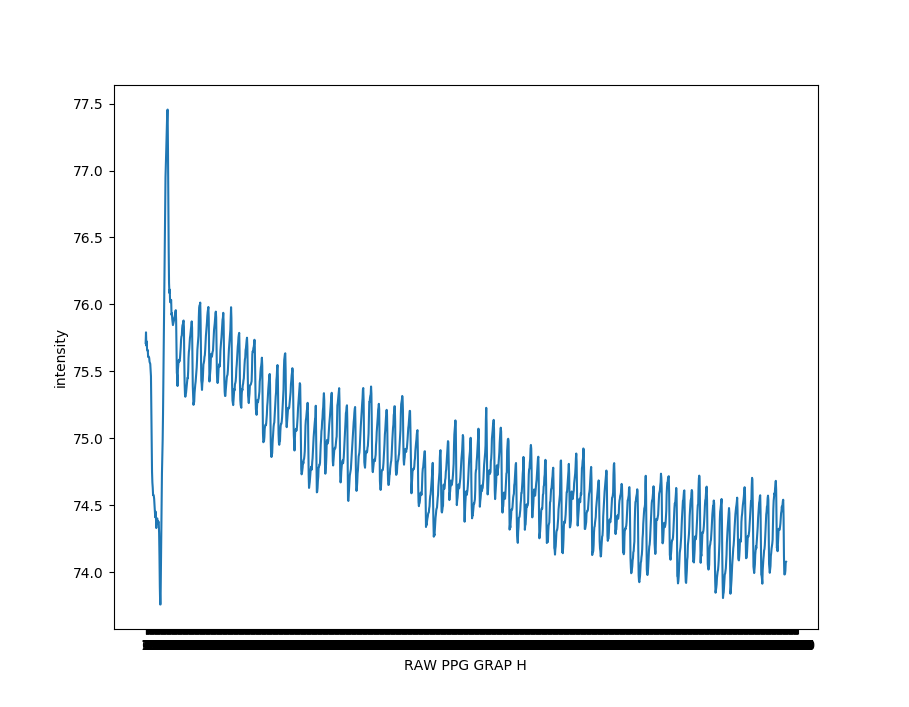

In [55]:
%matplotlib notebook
plt.plot(signalT[7])
plt.xlabel('RAW PPG GRAP H')
plt.ylabel('intensity')
plt.show()

# Apply Gausian Filter

<IPython.core.display.Javascript object>


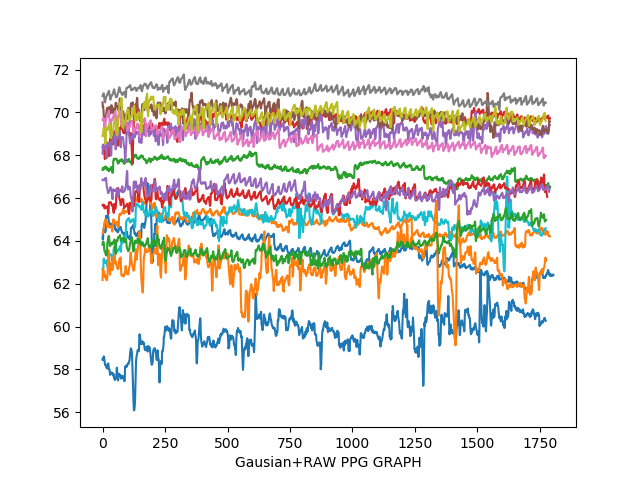

In [19]:
%matplotlib notebook
g_signal=gaussian_filter(signalT,sigma=0.5,cval=0.5, truncate=4.0)
#plt.figure(figsize=(10,8))
plt.xlabel('Gausian+RAW PPG GRAPH')
plt.plot(g_signal)

# Baseline ALS

In [40]:
#correcting baseline
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


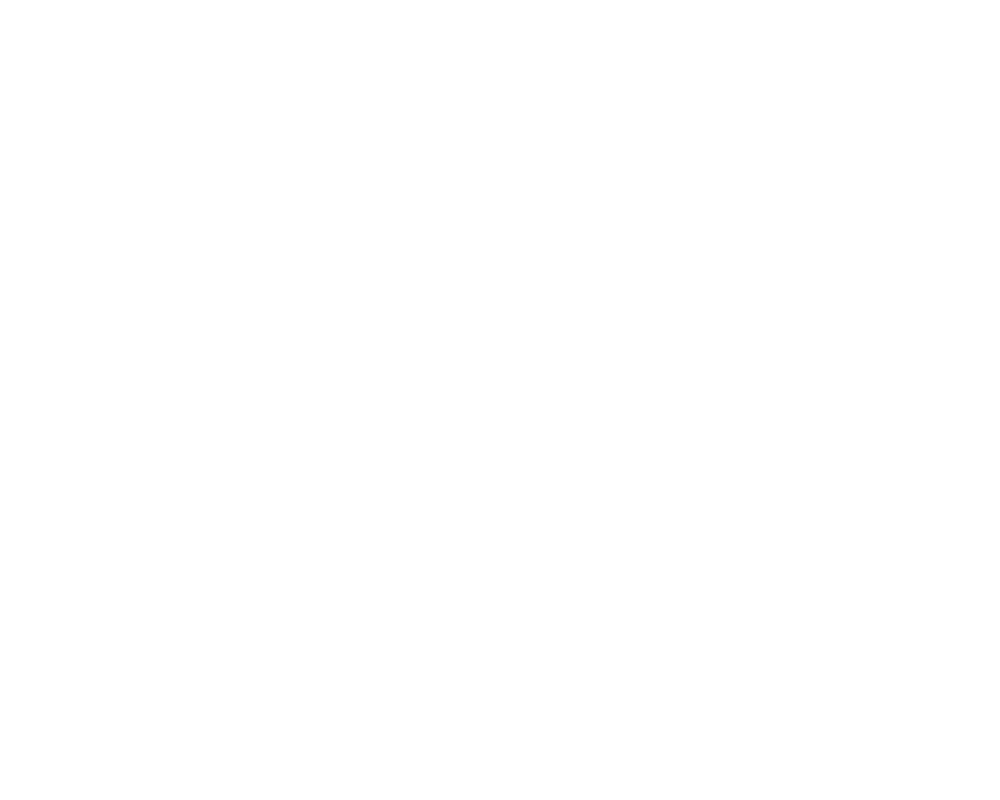

In [20]:
%matplotlib notebook
asx =[]
Corrected_base =[]
for i in range(len(g_signal)):
    asx.append(g_signal[i].flatten())
    base=asx[i]-baseline_als(asx[i], 1000, 0.05)
    Corrected_base.append(base)             
plt.figure(figsize=(10,8))
plt.xlabel('Corrected Baseline PPG GRAPH')
plt.plot(Corrected_base)

# Gausian Filter 2nd Time after Baseline ALS 

<IPython.core.display.Javascript object>


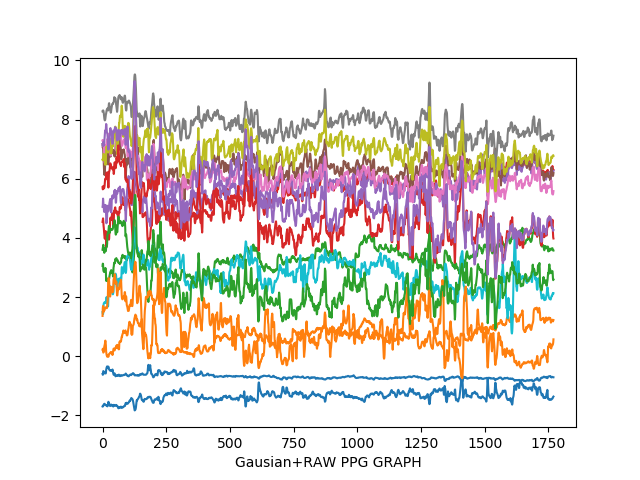

In [25]:
%matplotlib notebook
g_base_signal=gaussian_filter(Corrected_base,sigma=0.5,cval=0.5, truncate=5.0)
#plt.figure(figsize=(10,8))
plt.xlabel('Gausian+RAW PPG GRAPH')
plt.plot(g_base_signal)

In [33]:
%matplotlib notebook
from scipy.signal import savgol_filter
sig_filter = savgol_filter(Corrected_base, 5, polyorder = 3,deriv=0)
# Plot second derivative
plt.figure(figsize=(10,8))
with plt.style.context(('ggplot')):
    plt.plot(sig_filter)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

LinAlgError: SVD did not converge in Linear Least Squares